In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

2022-10-13 17:23:41.357740: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-13 17:23:41.357776: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [3]:
dateparse = lambda x: datetime.strptime(x, '%d-%b-%y')
df = pd.read_csv('../data_region.csv', parse_dates=['date'], date_parser=dateparse)
df = df.set_index('date')

In [4]:
df1 = df.loc["2015-02-01":"2016-09-01"]
df2 = df.loc["2016-03-01":"2017-09-30"]
df3 = df.loc["2017-09-01":"2019-04-02"]

In [5]:
df1.index[0].strftime('%A'), df2.index[0].strftime('%A'), df3.index[0].strftime('%A')

('Sunday', 'Tuesday', 'Friday')

In [6]:
df1.index[-1].strftime('%A'), df2.index[-1].strftime('%A'), df3.index[-1].strftime('%A')

('Thursday', 'Saturday', 'Tuesday')

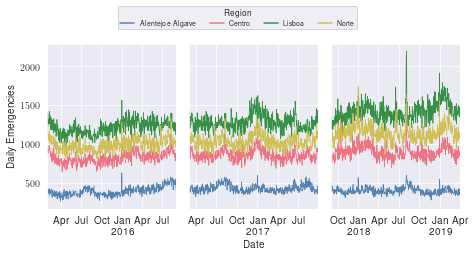

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17*cm, 8*cm), sharey=True)
axes[0].set(ylabel='Daily Emergencies')
df1.pivot_table(values="count",index="date",columns="region").plot(linewidth=.7, alpha=0.9, color=colors[0:4], legend=None, ax=axes[0], xlabel='')
df2.pivot_table(values="count",index="date",columns="region").plot(linewidth=.7, alpha=0.9, color=colors[0:4], legend=None, ax=axes[1], xlabel='Date')
df3.pivot_table(values="count",index="date",columns="region").plot(linewidth=.7, alpha=0.9, color=colors[0:4], legend=None, ax=axes[2], xlabel='')
leg = fig.legend(['Alentejo e Algarve', 'Centro', 'Lisboa', 'Norte'], title_fontsize='small', fontsize='x-small', title='Region', loc="lower center", bbox_to_anchor=(0.5,1), ncol=5)
for legobj in leg.legendHandles:
    legobj.set_linewidth(1.5)
plt.tight_layout()
plt.savefig('figures/emergencies_daily_region.pdf', bbox_inches = "tight")

### Create batches of training data (12 months)

In [8]:
def split_sequence(sequence, sequence_total, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence_total[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit LSTM model 

In [9]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(n_steps_in, 1)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=250, batch_size=32, callbacks=[callback])
    
    loss_per_epoch = model.history.history['loss']
    plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
    return model 

In [10]:
def train_predict(dataset, dataset_total, test, actual):
    n_steps_in, n_steps_out, slide = 7, 7, 1
    X, y = split_sequence(dataset, dataset_total, n_steps_in, n_steps_out, slide)
    
    # flatten input and output
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))
    
    print(X[0], y[0], len(X[0]), len(y[0]))
    model = fit(X, y, n_input, n_output)
    
    x_input = dataset[-n_steps_in:]
    x_input = x_input.reshape((1, n_input, 1))
    pred = model.predict(x_input).reshape(-1, 1)
    pred = scaler.inverse_transform(pred)
    #print(x_input,pred)
    
    mae, rmse, smape = list(), list(), list()  
    for i in range(0, len(test), n_steps_in):
        mae_aux, rmse_aux, smape_aux = measure_error(actual, pred, n_steps_in, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
        #print(actual[i:i+n_steps_in], pred, mae, rmse, smape)
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_input, 1))
        pred = model.predict(x_input).reshape(-1, 1)
        pred = scaler.inverse_transform(pred)
        #print(x_input, current_pred)
    
    return mae, rmse, smape

In [11]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [12]:
def measure_error(actual, pred, step, index):
    #print(actual[index:index+step], pred)
    mae = mean_absolute_error(array(actual[index:index+step]), pred)
    rmse = np.sqrt(mean_squared_error(array(actual[index:index+step]), pred))
    smape = sMAPE(array(actual[index:index+step]), pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

[0.38082194 0.51134014 0.45888174 0.50939846 0.3616438  0.6618557
 0.72532904 0.76503754 0.35616434 0.48865974 0.43914473 0.5545113
 0.27123284 0.5237113  0.4638158  0.5338347  0.2767123  0.51958764
 0.59539473 0.5526316  0.41643834 0.6041237  0.5246712  0.62030077
 0.41643834 0.5917525  0.50822365 0.60526323] [0.5164834  0.697513   0.5569693  0.59803355 0.5818392  0.5581261
 0.48640835] 28 7
Epoch 1/250


2022-10-13 17:23:45.123237: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-13 17:23:45.123268: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-13 17:23:45.123583: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


16/16 [==============================] - 1s 11ms/step - loss: 0.1146
Epoch 2/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0523
Epoch 3/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0147
Epoch 4/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0123
Epoch 5/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0117
Epoch 6/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0115
Epoch 7/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0114
Epoch 8/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0115
Epoch 9/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0115
Epoch 10/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0114
Epoch 11/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0116
Epoch 12/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0114
Epoch 13/250
16/16 [=================

16/16 [==============================] - 0s 15ms/step - loss: 0.0109
Epoch 102/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0110
Epoch 103/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0109
Epoch 104/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0109
Epoch 105/250
16/16 [==============================] - 0s 17ms/step - loss: 0.0110
Epoch 106/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0110
Epoch 107/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0111
Epoch 108/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0110
Epoch 109/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0109
Epoch 110/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0110
Epoch 111/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0113
Epoch 112/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0109
Epoch 113/250
16/1

16/16 [==============================] - 0s 13ms/step - loss: 0.0105
Epoch 200/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0104
Epoch 201/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0104
Epoch 202/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0104
Epoch 203/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0102
Epoch 204/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0107
Epoch 205/250
16/16 [==============================] - 0s 12ms/step - loss: 0.0106
Epoch 206/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0106
Epoch 207/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0104
Epoch 208/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0103
Epoch 209/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0102
Epoch 210/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0103
Epoch 211/250
16/1

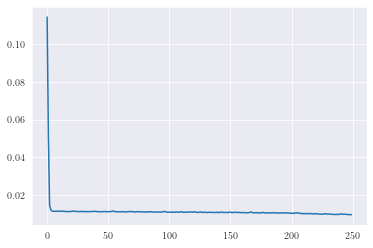

In [13]:
df1 = df1.pivot_table('count', 'date', 'region')
df1['Total'] = df1.sum(axis=1)
dataset = df1[['Alentejo e Algarve', 'Centro', 'Lisboa', 'Norte']].values
dataset = df1[['Alentejo e Algarve', 'Centro', 'Lisboa', 'Norte']].astype('float32')
dataset_total = df1[['Total']].values
dataset_total = df1[['Total']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset_total = scaler.fit_transform(dataset_total)
mae1, rmse1, smape1 = train_predict(dataset[:509], dataset_total[:509], dataset[509:], df1[['Total']][509:].values)

[0.23465705 0.5397849  0.63978505 0.4580152  0.4223827  0.48172045
 0.5286739  0.41221368 0.28519857 0.47526884 0.41756272 0.58969474
 0.3357401  0.57849455 0.3835125  0.40458012 0.19855595 0.26666665
 0.24551964 0.41221368 0.26714802 0.32688177 0.31003594 0.40648854
 0.38989174 0.5999999  0.5250895  0.54770994] [0.48446405 0.36905515 0.48953712 0.5859226  0.43310082 0.46797717
 0.5859226 ] 28 7
Epoch 1/250
16/16 [==============================] - 1s 15ms/step - loss: 0.1313
Epoch 2/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0440
Epoch 3/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0206
Epoch 4/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0180
Epoch 5/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0176
Epoch 6/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0176
Epoch 7/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0175
Epoch 8/250
16/16 [===============

16/16 [==============================] - 0s 16ms/step - loss: 0.0165
Epoch 97/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0165
Epoch 98/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0165
Epoch 99/250
16/16 [==============================] - 0s 17ms/step - loss: 0.0164
Epoch 100/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0165
Epoch 101/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0165
Epoch 102/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0164
Epoch 103/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0163
Epoch 104/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0163
Epoch 105/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0165
Epoch 106/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0168
Epoch 107/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0164
Epoch 108/250
16/16 [

16/16 [==============================] - 0s 13ms/step - loss: 0.0147
Epoch 195/250
16/16 [==============================] - 0s 12ms/step - loss: 0.0146
Epoch 196/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0151
Epoch 197/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0146
Epoch 198/250
16/16 [==============================] - 0s 12ms/step - loss: 0.0145
Epoch 199/250
16/16 [==============================] - 0s 12ms/step - loss: 0.0144
Epoch 200/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0144
Epoch 201/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0144
Epoch 202/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0142
Epoch 203/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0142
Epoch 204/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0142
Epoch 205/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0143
Epoch 206/250
16/1

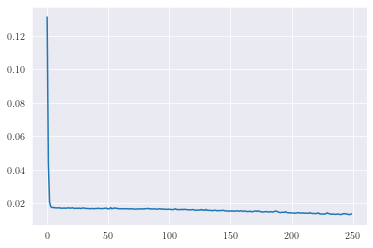

In [14]:
df2 = df2.pivot_table('count', 'date', 'region')
df2['Total'] = df2.sum(axis=1)
dataset = df2[['Alentejo e Algarve', 'Centro', 'Lisboa', 'Norte']].values
dataset = df2[['Alentejo e Algarve', 'Centro', 'Lisboa', 'Norte']].astype('float32')
dataset_total = df2[['Total']].values
dataset_total = df2[['Total']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset_total = scaler.fit_transform(dataset_total)
mae2, rmse2, smape2 = train_predict(dataset[:509], dataset_total[:509], dataset[509:], df2[['Total']][509:].values)

[0.340625   0.17045456 0.12322283 0.06815517 0.690625   0.20328277
 0.2085309  0.12103415 0.596875   0.1098485  0.06919432 0.13983548
 0.49375004 0.18181819 0.17345977 0.19271445 0.32812506 0.09469694
 0.05023706 0.08460641 0.46875006 0.16035348 0.13080573 0.30669808
 0.403125   0.1691919  0.13364935 0.30434787] [0.18345737 0.13484907 0.132105   0.16699326 0.10309684 0.12936103
 0.10427284] 28 7
Epoch 1/250
16/16 [==============================] - 1s 14ms/step - loss: 0.0605
Epoch 2/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0248
Epoch 3/250
16/16 [==============================] - 0s 18ms/step - loss: 0.0131
Epoch 4/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0121
Epoch 5/250
16/16 [==============================] - 0s 19ms/step - loss: 0.0122
Epoch 6/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0118
Epoch 7/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0116
Epoch 8/250
16/16 [===============

16/16 [==============================] - 0s 13ms/step - loss: 0.0102
Epoch 97/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0102
Epoch 98/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0103
Epoch 99/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0103
Epoch 100/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0103
Epoch 101/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0103
Epoch 102/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0101
Epoch 103/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0103
Epoch 104/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0103
Epoch 105/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0105
Epoch 106/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0104
Epoch 107/250
16/16 [==============================] - 0s 18ms/step - loss: 0.0102
Epoch 108/250
16/16 [

16/16 [==============================] - 0s 15ms/step - loss: 0.0087
Epoch 195/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0085
Epoch 196/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0086
Epoch 197/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0087
Epoch 198/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0086
Epoch 199/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0085
Epoch 200/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0086
Epoch 201/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0085
Epoch 202/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0086
Epoch 203/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0085
Epoch 204/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0085
Epoch 205/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0084
Epoch 206/250
16/1

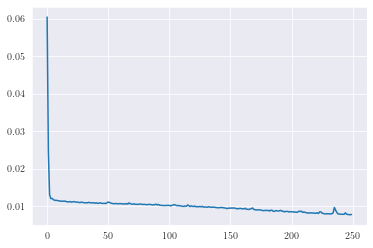

In [15]:
df3 = df3.pivot_table('count', 'date', 'region')
df3['Total'] = df3.sum(axis=1)
dataset = df3[['Alentejo e Algarve', 'Centro', 'Lisboa', 'Norte']].values
dataset = df3[['Alentejo e Algarve', 'Centro', 'Lisboa', 'Norte']].astype('float32')
dataset_total = df3[['Total']].values
dataset_total = df3[['Total']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset_total = scaler.fit_transform(dataset_total)
mae3, rmse3, smape3 = train_predict(dataset[:509], dataset_total[:509], dataset[509:], df3[['Total']][509:].values)

In [16]:
mae = mae1 + mae2 + mae3
rmse = rmse1 + rmse2 + rmse3
smape = smape1 + smape2 + smape3

### Calculate Error

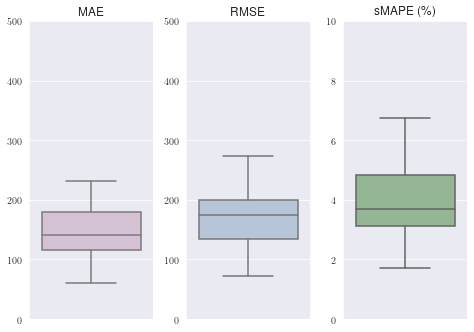

In [17]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 500))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 500))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 10))
plt.tight_layout()
#plt.savefig('figures/emergencies_lstm_daily_region_boxplot.pdf')

In [19]:
emer_lstm_day_region = [mae,rmse,smape]
%store emer_lstm_day_region

Stored 'emer_lstm_day_region' (list)
